In [2]:
import tensorflow as tf
import numpy as np
import os
import sys
from fxpmath import Fxp

In [3]:
# Path para importacion de funciones
dir_actual    = os.path.abspath('')
dir_parent = os.path.dirname(dir_actual)
if not dir_parent in sys.path: sys.path.append(dir_parent)

## Parametros de Simulacion

In [4]:
#Parametros de Cuantizacion
bits_activaciones      = 12
precision_activaciones = 6
bits_pesos_conv        = 12
precision_pesos_conv   = 8
bits_pesos_fc          = 6
precision_pesos_fc     = 6

# Parametros de buffer input/output
Malpc = 12    #Maximo de activaciones leidas en un ciclo
Maepc = 12    #Maximo de activaciones escritas en un ciclo
bits_lectura_input    = Malpc*bits_activaciones
bits_escritura_output = Maepc*bits_activaciones

#Parametros de la matriz de dsp slices.
filas      = Malpc
dsp_slices = 720
columnas   = dsp_slices/filas

#Parametros de Buffers de pesos
Mpclpc = 24   # Maximo de pesos convolucionales leidos en un ciclo
Mpflpc = 48   # Maximo de pesos full conectados leidos en un ciclo
bits_lectura_pesos_conv  = Mpclpc*bits_pesos_conv
bits_lectura_pesos_fc    = Mpflpc*bits_pesos_fc

#Tamaño del buffer
IOBuffer_size = 4704*bits_activaciones

## Carga del modelo y sus pesos

In [5]:
from models import Lenet_body
from models import Weight_Quantization

# Creacion de la red
Qinput_layer  = tf.keras.Input((28, 28, 1))
Qoutput_layer = Lenet_body(Qinput_layer, Quantization = True, word_size = bits_activaciones, frac_size = precision_activaciones)
QLenet = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

# Carga de los pesos
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')
QLenet.load_weights(Wgt_dir)

# Cuantizacion de los pesos
Weight_Quantization(model = QLenet, 
                    Frac_Bits = precision_pesos_conv, Int_Bits = (bits_pesos_conv-precision_pesos_conv-1),
                    Dense_Frac_Bits = precision_pesos_fc, Dense_Int_Bits = (bits_pesos_fc-precision_pesos_fc-1))

## Carga del dataset

In [6]:
from models import Quantization_layer
# Carga
(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Normalizacion
x_test = x_test/255.0
# Cuantizacion
x_test = Quantization_layer(x_test)
# Expandiendo la dimensionalidad de 28x28 a 28x28x1 (Numero de canales)
x_test = tf.expand_dims(x_test,axis=-1)
# Conversion en dataset
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)

## Simulacion

In [25]:
# Bufferes
IOBuffer_1 = np.zeros(IOBuffer_size,dtype=int)
IOBuffer_2 = np.zeros(IOBuffer_size,dtype=int)

# Diccionario de estadisticas de los buffers
stats_IOBuffer_1 = {"ultimo_valor"    : np.zeros(IOBuffer_size,dtype=int),
                    "ciclos_1"        : np.zeros(IOBuffer_size,dtype=int),
                    "ciclos_0"        : np.zeros(IOBuffer_size,dtype=int),
                    "cambios_logicos" :np.zeros(IOBuffer_size,dtype=int)}
stats_IOBuffer_2 = {"ultimo_valor"    : np.zeros(IOBuffer_size,dtype=int),
                    "ciclos_1"        : np.zeros(IOBuffer_size,dtype=int),
                    "ciclos_0"        : np.zeros(IOBuffer_size,dtype=int),
                    "cambios_logicos" :np.zeros(IOBuffer_size,dtype=int)}

import simulation
import time
from functions import save_obj, load_obj, Load_Image

# Variables de simulacion
simulation.Malpc            = Malpc
simulation.Maepc            = Maepc
simulation.Mpclpc           = Mpclpc
simulation.Mpflpc           = Mpflpc
simulation.filas            = filas
simulation.columnas         = columnas
simulation.Word_bits        = bits_activaciones
simulation.Frac_bits        = precision_activaciones
simulation.QLenet           = QLenet
simulation.IOBuffer_1       = IOBuffer_1
simulation.stats_IOBuffer_1 = stats_IOBuffer_1
simulation.IOBuffer_2       = IOBuffer_2
simulation.stats_IOBuffer_2 = stats_IOBuffer_2


iterator   = iter(test_dataset)
ciclos     = 0
index      = 0
batch_size = 512
t = time.time()
while index < batch_size:
    image = next(iterator)
    Load_Image(IOBuffer_1,image, Word_bits = bits_activaciones, Frac_bits = precision_activaciones)
    ciclos += simulation.Lenet_Simulation(image)
    index = index + 1
save_obj(stats_IOBuffer_1,'stats_B1')
save_obj(stats_IOBuffer_2,'stats_B2')
print('Tiempo de simulacion:',time.time()-t)
save_obj(ciclos,'numero_de_ciclos')


Tiempo de simulacion: 1028.0153663158417


In [26]:
ciclos = load_obj('numero_de_ciclos')
print('Total de ciclos utilizados:',ciclos)
stats_IOBuffer_1 = load_obj('stats_B1')
stats_IOBuffer_2 = load_obj('stats_B2')

stats_IOBuffer_1['ciclos_0'] = ciclos - stats_IOBuffer_1['ciclos_1'] 
stats_IOBuffer_2['ciclos_0'] = ciclos - stats_IOBuffer_2['ciclos_1'] 

Total de ciclos utilizados: 1259520


#  Estadisticas buffer 1

# de Celdas sin cambios logicos: 42438


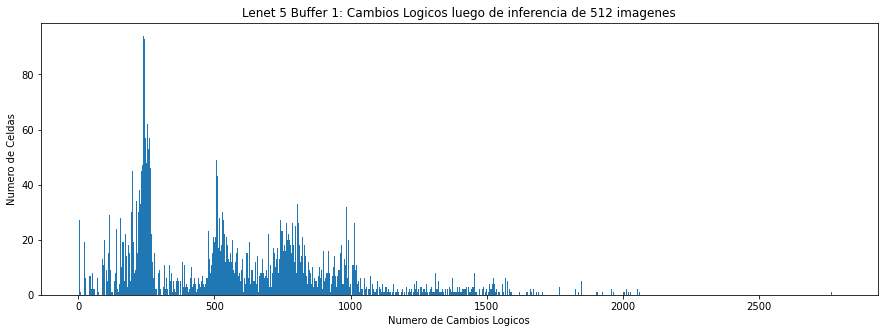

In [42]:
import matplotlib.pyplot as plt
unique, counts = np.unique(stats_IOBuffer_1['cambios_logicos'], return_counts=True)
print('# de Celdas sin cambios logicos:', counts[0])
plt.figure(figsize=(15,5))
plt.title('Lenet 5 Buffer 1: Cambios Logicos luego de inferencia de 512 imagenes')
plt.xlabel('Numero de Cambios Logicos')
plt.ylabel('Numero de Celdas')
plt.bar(unique[1:],counts[1:],width=1);
plt.savefig('Figuras/Estadisticas_de_Buffers/Lenet 5 Buffer 1 Cambios Logicos.png')

# de Celdas nunca en alto (siempre con valor 0): 42523


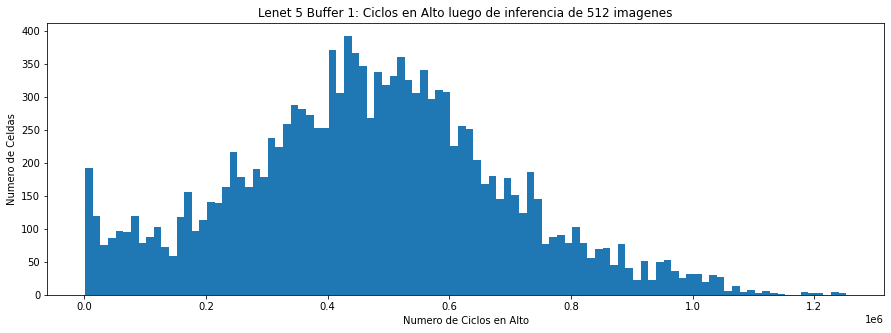

In [43]:
unique, counts = np.unique(stats_IOBuffer_1['ciclos_1'], return_counts=True)
print('# de Celdas nunca en alto (siempre con valor 0):', counts[0])
plt.figure(figsize=(15,5))
plt.title('Lenet 5 Buffer 1: Ciclos en Alto luego de inferencia de 512 imagenes')
plt.xlabel('Numero de Ciclos en Alto')
plt.ylabel('Numero de Celdas')
plt.hist(stats_IOBuffer_1['ciclos_1'][stats_IOBuffer_1['ciclos_1'] > unique[0]],bins=100);
plt.savefig('Figuras/Estadisticas_de_Buffers/Lenet 5 Buffer 1 Ciclos en Alto.png')

# de Celdas siempre en bajo (siempre con valor 0): 42523


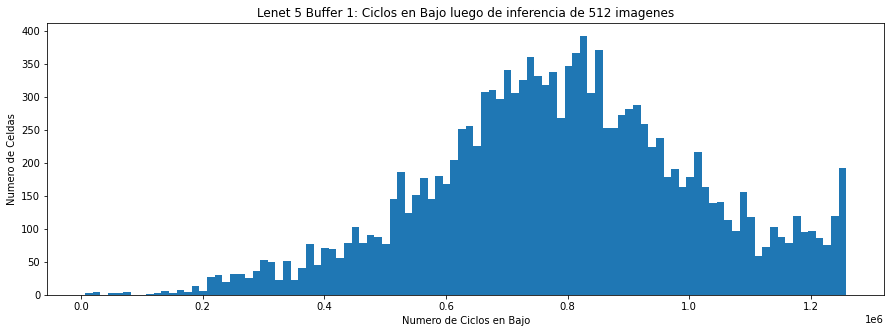

In [44]:
unique, counts = np.unique(stats_IOBuffer_1['ciclos_0'], return_counts=True)
print('# de Celdas siempre en bajo (siempre con valor 0):', counts[-1])
plt.figure(figsize=(15,5))
plt.title('Lenet 5 Buffer 1: Ciclos en Bajo luego de inferencia de 512 imagenes')
plt.xlabel('Numero de Ciclos en Bajo')
plt.ylabel('Numero de Celdas')
plt.hist(stats_IOBuffer_1['ciclos_0'][stats_IOBuffer_1['ciclos_0'] < unique[-1]],bins=100);
plt.savefig('Figuras/Estadisticas_de_Buffers/Lenet 5 Buffer 1 Ciclos en Bajo.png')

# Estadisticas buffer 2

# de Celdas sin cambios logicos: 413


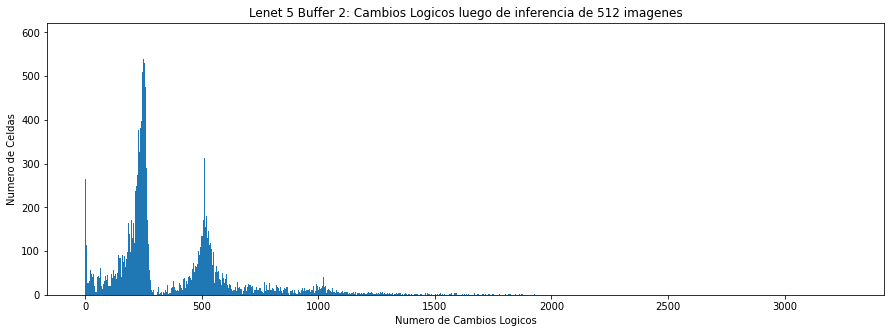

In [45]:
unique, counts = np.unique(stats_IOBuffer_2['cambios_logicos'], return_counts=True)
print('# de Celdas sin cambios logicos:', counts[0])
plt.figure(figsize=(15,5))
plt.title('Lenet 5 Buffer 2: Cambios Logicos luego de inferencia de 512 imagenes')
plt.xlabel('Numero de Cambios Logicos')
plt.ylabel('Numero de Celdas')
plt.bar(unique[1:],counts[1:],width=1);
plt.savefig('Figuras/Estadisticas_de_Buffers/Lenet 5 Buffer 2 Cambios Logicos.png')

# de Celdas nunca en alto (siempre con valor 0): 623


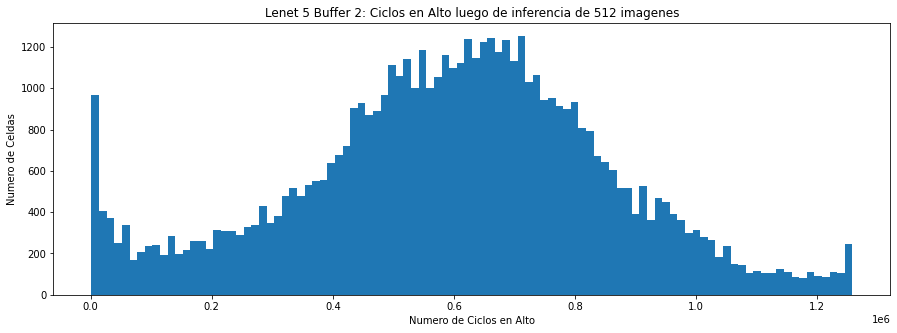

In [46]:
unique, counts = np.unique(stats_IOBuffer_2['ciclos_1'], return_counts=True)
print('# de Celdas nunca en alto (siempre con valor 0):', counts[0])
plt.figure(figsize=(15,5))
plt.title('Lenet 5 Buffer 2: Ciclos en Alto luego de inferencia de 512 imagenes')
plt.xlabel('Numero de Ciclos en Alto')
plt.ylabel('Numero de Celdas')
plt.hist(stats_IOBuffer_2['ciclos_1'][stats_IOBuffer_2['ciclos_1'] > unique[0]],bins=100);
plt.savefig('Figuras/Estadisticas_de_Buffers/Lenet 5 Buffer 2 Ciclos en Alto.png')

# de Celdas siempre en bajo (siempre con valor 0): 623


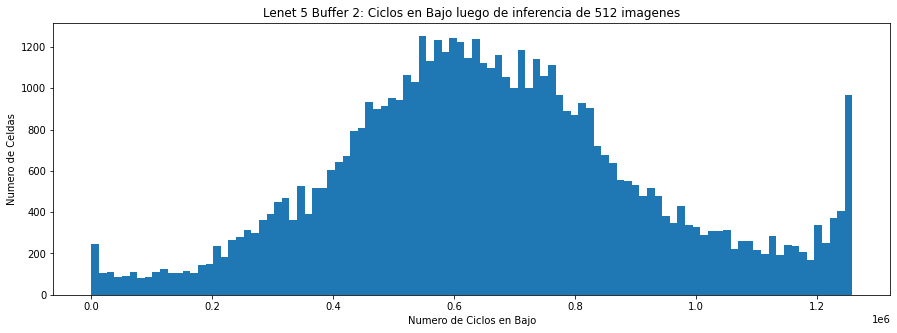

In [50]:
unique, counts = np.unique(stats_IOBuffer_2['ciclos_0'], return_counts=True)
print('# de Celdas siempre en bajo (siempre con valor 0):', counts[-1])
plt.figure(figsize=(15,5))
plt.title('Lenet 5 Buffer 2: Ciclos en Bajo luego de inferencia de 512 imagenes')
plt.xlabel('Numero de Ciclos en Bajo')
plt.ylabel('Numero de Celdas')
plt.hist(stats_IOBuffer_2['ciclos_0'][stats_IOBuffer_2['ciclos_0'] < unique[-1]],bins=100);
plt.savefig('Figuras/Estadisticas_de_Buffers/Lenet 5 Buffer 2 Ciclos en Bajo.png')